# Model Understanding with Captum

## Introduction

Captum’s approach to model interpretability is in terms of attributions. There are three kinds of attributions available in Captum:

- Feature Attribution - seeks to explain a particular output in terms of features of the input that generated it. Explaining whether a movie review was positive or negative in terms of certain words in the review is an example of feature attribution.  
    
    “Which features of the input were most important for this prediction?”
        - In NLP: Which words made a sentence classified as positive or negative?
        - In vision: Which pixels most influenced the model to recognize a cat?

- Layer Attribution - examines the activity of a model’s hidden layer subsequent to a particular input. Examining the spatially-mapped output of a convolutional layer in response to an input image in an example of layer attribution. 
    - Goal: Explain what happens inside the network, at the layer level.
    - Question: “Which features or regions in this layer respond most to a given input?”

    Example user cases:
        - Visualizing activations of a CNN layer for an image
        - Understanding how attention layers behave in a transformer

- Neuron Attribution - is analagous to layer attribution, but focuses on the activity of a single neuron.
    - Goal: Go even deeper — analyze the contribution to a single neuron.
    - Question: “How important is this input for activating neuron X in layer Y?”

    Use cases:
    - Understanding what specific neurons detect (edges, textures, or semantic features) 
    - Debugging neuron saturation or dead neurons

In this interactive notebook, we’ll look at Feature Attribution and Layer Attribution.

Each of the three attribution types has multiple attribution algorithms associated with it. Many attribution algorithms fall into two broad categories:

- Gradient-based algorithms - calculate the backward gradients of a model output, layer output, or neuron activation with respect to the input. Integrated Gradients (for features), Layer Gradient * Activation, and Neuron Conductance are all gradient-based algorithms.

- Perturbation-based algorithms - examine the changes in the output of a model, layer, or neuron in response to changes in the input. The input perturbations may be directed or random. Occlusion, Feature Ablation, and Feature Permutation are all perturbation-based algorithms.

We’ll be examining algorithms of both types below.


Note:  pip install captum Flask-Compress - it uninstalled numpy 2.3.2 an replaced it with 1.26.4

# A First Example
To start, let’s take a simple, visual example. We’ll start with a ResNet model pretrained on the ImageNet dataset. We’ll get a test input, and use different Feature Attribution algorithms to examine how the input images affect the output, and see a helpful visualization of this input attribution map for some test images.

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

Now we’ll use the TorchVision model library to download a pretrained ResNet. Since we’re not training, we’ll place it in evaluation mode for now.

In [2]:
model = models.resnet18(weights='IMAGENET1K_V1')
model = model.eval()

The place where you got this interactive notebook should also have an img folder with a file cat.jpg in it.

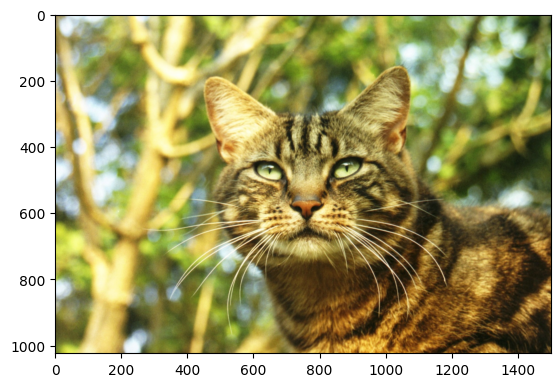

In [3]:
test_img = Image.open('data/img/cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

test_img = Image.open('data/img/wesley_1.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

test_img = Image.open('data/img/wesley_2.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

Our ResNet model was trained on the ImageNet dataset, and expects images to be of a certain size, with the channel data normalized to a specific range of values. We’ll also pull in the list of human-readable labels for the categories our model recognizes - that should be in the img folder as well.

In [4]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

labels_path = 'data/img/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Now, we can ask the question: What does our model think this image represents?

In [5]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: tabby ( 0.5688222050666809 )


We’ve confirmed that ResNet thinks our image of a cat is, in fact, a cat. But why does the model think this is an image of a cat?

For the answer to that, we turn to Captum.

# Feature Attribution with Integrated Gradients
Feature attribution attributes a particular output to features of the input. It uses a specific input - here, our test image - to generate a map of the relative importance of each input feature to a particular output feature.

Integrated Gradients - is one of the feature attribution algorithms available in Captum. Integrated Gradients assigns an importance score to each input feature by approximating the integral of the gradients of the model’s output with respect to the inputs.

In our case, we’re going to be taking a specific element of the output vector - that is, the one indicating the model’s confidence in its chosen category - and use Integrated Gradients to understand what parts of the input image contributed to this output.

Once we have the importance map from Integrated Gradients, we’ll use the visualization tools in Captum to give a helpful representation of the importance map. Captum’s visualize_image_attr() function provides a variety of options for customizing display of your attribution data. Here, we pass in a custom Matplotlib color map.

Running the cell with the integrated_gradients.attribute() call will usually take a minute or two.

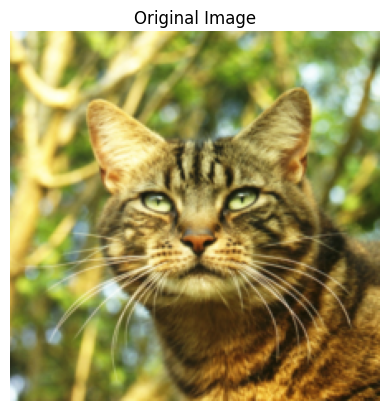

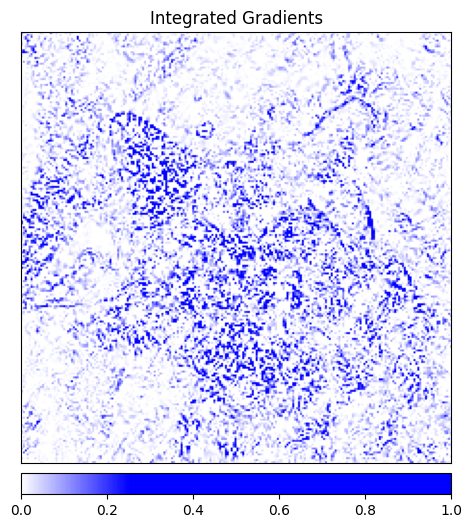

In [6]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

# Show the original image for comparison
# _ = viz.visualize_image_attr(None,
#                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                      method="original_image", title="Original Image")
# Show original image
plt.imshow(np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1, 2, 0)))
plt.title("Original Image")
plt.axis("off")
plt.show()

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

# Feature Attribution with Occlusion

Gradient-based attribution methods help to understand the model in terms of directly computing out the output changes with respect to the input. Perturbation-based attribution methods approach this more directly, by introducing changes to the input to measure the effect on the output. Occlusion is one such method. It involves replacing sections of the input image, and examining the effect on the output signal.

Below, we set up Occlusion attribution. Similarly to configuring a convolutional neural network, you can specify the size of the target region, and a stride length to determine the spacing of individual measurements. We’ll visualize the output of our Occlusion attribution with visualize_image_attr_multiple(), showing heat maps of both positive and negative attribution by region, and by masking the original image with the positive attribution regions. The masking gives a very instructive view of what regions of our cat photo the model found to be most “cat-like”.

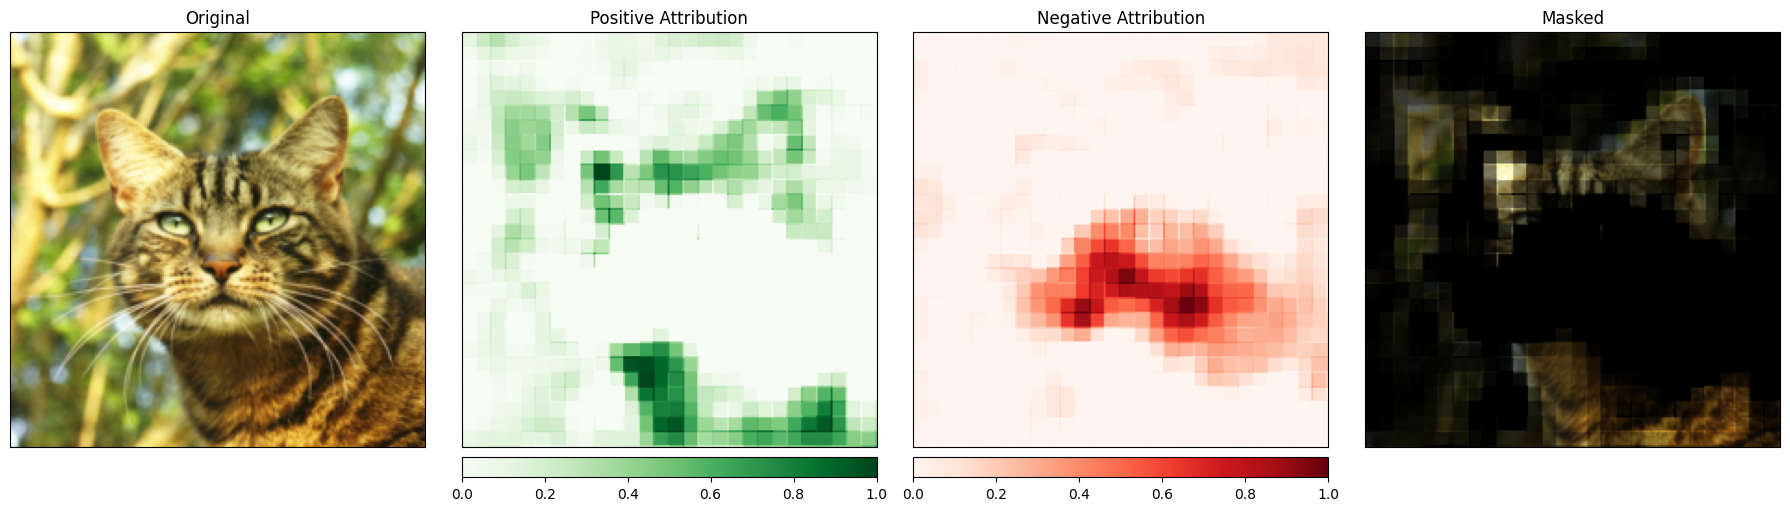

In [7]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

Again, we see greater significance placed on the region of the image that contains the cat.

# Layer Attribution with Layer GradCAM

Layer Attribution allows you to attribute the activity of hidden layers within your model to features of your input. Below, we’ll use a layer attribution algorithm to examine the activity of one of the convolutional layers within our model.

GradCAM computes the gradients of the target output with respect to the given layer, averages for each output channel (dimension 2 of output), and multiplies the average gradient for each channel by the layer activations. The results are summed over all channels. GradCAM is designed for convnets; since the activity of convolutional layers often maps spatially to the input, GradCAM attributions are often upsampled and used to mask the input.

Layer attribution is set up similarly to input attribution, except that in addition to the model, you must specify a hidden layer within the model that you wish to examine. As above, when we call attribute(), we specify the target class of interest.

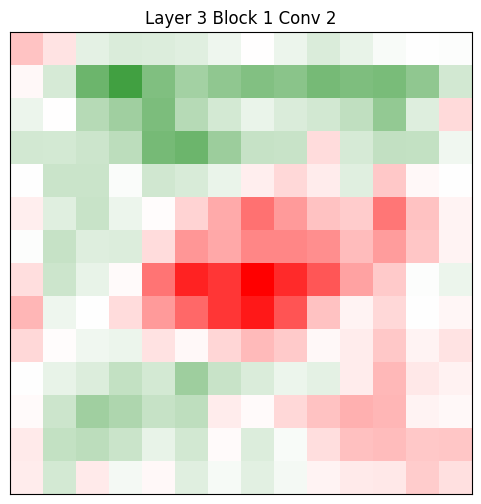

In [8]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")

We’ll use the convenience method interpolate() in the LayerAttribution base class to upsample this attribution data for comparison to the input image.

torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


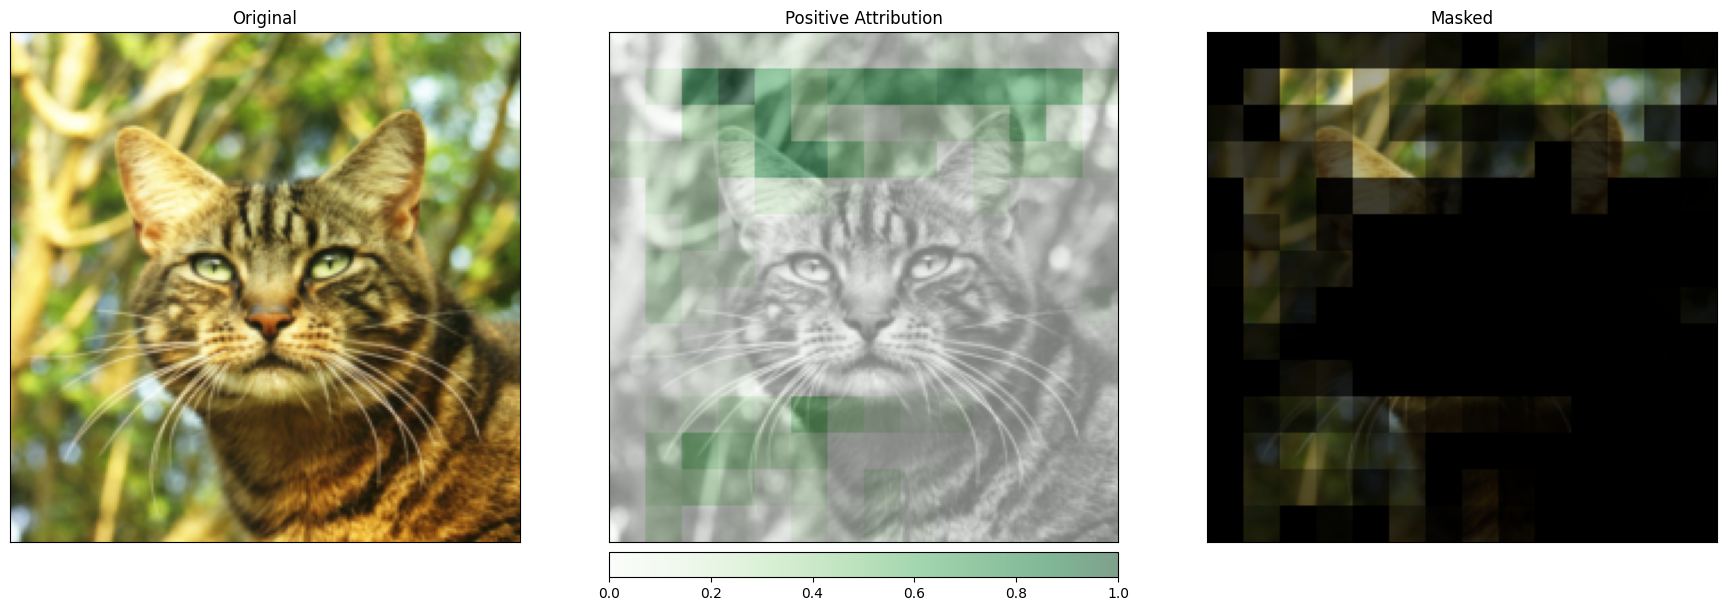

In [9]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

Visualizations such as this can give you novel insights into how your hidden layers respond to your input.

# Visualization with Captum Insights

Captum Insights is an interpretability visualization widget built on top of Captum to facilitate model understanding. Captum Insights works across images, text, and other features to help users understand feature attribution. It allows you to visualize attribution for multiple input/output pairs, and provides visualization tools for image, text, and arbitrary data.

In this section of the notebook, we’ll visualize multiple image classification inferences with Captum Insights.

First, let’s gather some image and see what the model thinks of them. For variety, we’ll take our cat, a teapot, and a trilobite fossil:

In [10]:
imgs = ['data/img/cat.jpg', 'data/img/teapot.jpg', 'data/img/trilobite.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: tabby / 281  ( 0.5688222050666809 )
Predicted: teapot / 849  ( 0.9914801120758057 )
Predicted: trilobite / 69  ( 0.9999061822891235 )


…and it looks like our model is identifying them all correctly - but of course, we want to dig deeper. For that we’ll use the Captum Insights widget, which we configure with an AttributionVisualizer object, imported below. The AttributionVisualizer expects batches of data, so we’ll bring in Captum’s Batch helper class. And we’ll be looking at images specifically, so well also import ImageFeature.

We configure the AttributionVisualizer with the following arguments:
- An array of models to be examined (in our case, just the one)
- A scoring function, which allows Captum Insights to pull out the top-k predictions from a model 
- An ordered, human-readable list of classes our model is trained on
- A list of features to look for - in our case, an ImageFeature
- A dataset, which is an iterable object returning batches of inputs and labels - just like you’d use for training

In [11]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i

input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[282,849,69])]
)

Note that running the cell above didn’t take much time at all, unlike our attributions above. That’s because Captum Insights lets you configure different attribution algorithms in a visual widget, after which it will compute and display the attributions. That process will take a few minutes.

Running the cell below will render the Captum Insights widget. You can then choose attributions methods and their arguments, filter model responses based on predicted class or prediction correctness, see the model’s predictions with associated probabilities, and view heatmaps of the attribution compared with the original image.

In [13]:
import captum
print(f"captum version: {captum.__version__}")

# Check if insights module is available
try:
    from captum.insights import AttributionVisualizer
    print("Captum Insights is available!")
except ImportError as e:
    print(f"Insights import error: {e}")

Captum version: 0.8.0
Captum Insights is available!


In [14]:
visualizer.render()    # this does mork for captum 0.8.0.  chatGPT suggested to wait for captum 0.9.0/

CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()